In [2]:
# Get data from bg431 and STM32F4
import serial
import math
import time
from bg431Communication import *

#######################################################################################
def getDataFromF4(serial_portF4):
    readSerialThread = SerialThread(serial_portF4, 20000)
    readSerialThread.start()
    serial_portF4.write(np.array(int16_to_int8(2), np.uint8))  # get data
    while not readSerialThread.isFinished():
        pass
    serial_data = readSerialThread.getSerialData()
    # res = serial_data.view(np.float32)
    res = serial_data.view(np.int16)
    return res
#######################################################################################
def startWriteF4(serial_portF4):
    serial_portF4.write(np.array(int16_to_int8(1), np.uint8))
    time.sleep(.01)
    serial_portF4.write(np.array(int16_to_int8(1), np.uint8))  # start write
#######################################################################################
def intAngleToContinousAngle(angle, minValue, valSize):
    contAngle = np.zeros(len(angle))
    counter = 0
    for i in range(len(angle)-1):
        contAngle[i] = angle[i] - minValue + valSize*counter
        if angle[i+1] < angle[i]:
            counter += 1
    contAngle = contAngle/valSize*360
    return contAngle
#######################################################################################

serial_portBG431 = serial.Serial(
port='/dev/ttyACM0',\
baudrate=1843200,\
parity=serial.PARITY_NONE,\
stopbits=serial.STOPBITS_ONE,\
bytesize=serial.EIGHTBITS,\
timeout=0.1)

serial_portF4 = serial.Serial(
port='/dev/ttyACM2',
baudrate=115200,
parity=serial.PARITY_NONE,
stopbits=serial.STOPBITS_ONE,
bytesize=serial.EIGHTBITS,
timeout=0.1)

print("connected to: " + serial_portBG431.portstr)
print("connected to: " + serial_portF4.portstr)

connected to: /dev/ttyACM0
connected to: /dev/ttyACM2


In [5]:
version, DATA_CRC, RX_maxSize, TXS_maxSize, TXA_maxSize = decodeBEACON(send4BytesToSerial(serial_portBG431, getBEACON(version=0, RX_maxSize=3, TXS_maxSize=3, TXA_maxSize=32)))
time.sleep(.1)
packetNumber, ipID, cbit, Nbit = decodePING(send4BytesToSerial(serial_portBG431, getPING(packetNumber=0)))
time.sleep(.1)
speedKp = 15000
speedKpDiv = 2048/8/2
speedKi = 6000
speedKiDiv = 16384/2
speedKd = 0
speedKdDiv = 16


In [12]:
arr = sendManyBytesToSerial(serial_portBG431, createDATA_PACKET(setREG([MC_REG_SPEED_KP, MC_REG_SPEED_KI, MC_REG_SPEED_KD,
                                                                        MC_REG_SPEED_KP_DIV, MC_REG_SPEED_KI_DIV, MC_REG_SPEED_KD_DIV],
                                                                       [speedKp, speedKi, speedKd,
                                                                        math.log2(speedKpDiv), math.log2(speedKiDiv), math.log2(speedKdDiv)])))
time.sleep(.1)
# arr = sendManyBytesToSerial(serial_port, createDATA_PACKET(getREG([MC_REG_SPEED_KP,  MC_REG_SPEED_KI, MC_REG_SPEED_KD,
#                                                                    MC_REG_SPEED_KP_DIV, MC_REG_SPEED_KI_DIV, MC_REG_SPEED_KD_DIV])))  # set speed PID values
# data = decodeRegValues(arr, [MC_REG_SPEED_KP,  MC_REG_SPEED_KI, MC_REG_SPEED_KD, 
#                              MC_REG_SPEED_KP_DIV, MC_REG_SPEED_KI_DIV, MC_REG_SPEED_KD_DIV])
# time.sleep(.1)

decodeCommandResult(sendManyBytesToSerial(serial_portBG431, createDATA_PACKET(getCOMMAND(START_MOTOR[0]))))
time.sleep(3)

rpmmeanarr =      np.array([2500, 2600, 2700, 2800, 2900, 3000, 2900, 2800, 2700, 2600])#[1800, 2500, 2000, 1600, 3000, 2500, 1900, 2100, 2300, 1800]
rpmDoubleAmparr = np.array([ 300,  300,  300,  300,  300,  300,  300,  300,  300,  300])#[100,   300,  200,  200,  300,  100,  150,  180,  200,  100]
phaserr =         np.array([10,    180,  270,   90,  135,  224,  355,    0,   25,   74])
rpmmean = 2500
rpmDoubleAmp = 300
phase = 0
sinParams = np.append(np.append(int32_to_int8(rpmmean),int16_to_int8(rpmDoubleAmp)),int16_to_int8(phase))
arr = sendManyBytesToSerial(serial_portBG431, createDATA_PACKET(setREG([MC_REG_SPEED_SIN],[sinParams])))   # Set sin
time.sleep(1)

startWriteF4(serial_portF4)
arr = sendManyBytesToSerial(serial_portBG431, createDATA_PACKET(setREG([MC_REG_DBG_START_WRITE],[[]])))    # Start Write
time.sleep(.01)
for i in range(10):
    sinParams = np.append(np.append(int32_to_int8(rpmmeanarr[i]),int16_to_int8(rpmDoubleAmparr[i])),int16_to_int8(phaserr[i]))
    arr = sendManyBytesToSerial(serial_portBG431, createDATA_PACKET(setREG([MC_REG_SPEED_SIN],[sinParams])))   # Set sin
    time.sleep(.1)
res = sendManyBytesToSerial(serial_portBG431, createDATA_PACKET(getCOMMAND(STOP_MOTOR[0])))                # Stop motor
decodeCommandResult(res)
time.sleep(.5)

arr = sendManyBytesToSerial(serial_portBG431, createDATA_PACKET(getCOMMAND(GET_DBG_DATA[0])))
arr = arr.view(np.int16)

f4data = getDataFromF4(serial_portF4)

In [13]:
mecAngle = arr[:1024]
tarSpeedHz = arr[1024:2048]/10
elAngle = arr[2048:3072]

encAngle = f4data[:1024]
spiAngle = 360-f4data[1024:]/50

SPEED_LOOP_FREQUENCY_HZ = 1000
mecContAngle = intAngleToContinousAngle(mecAngle, -2**15, 2**16)
elContAngle = intAngleToContinousAngle(elAngle, -2**15, 2**16)
encContAngle = intAngleToContinousAngle(encAngle, 0, 4000)
spiContAngle = intAngleToContinousAngle(spiAngle, 0, 360)
contMecAngleSpeedHz = np.diff(mecContAngle)*SPEED_LOOP_FREQUENCY_HZ/360

encWindow = 2
contEncAngleSpeedHz = (encContAngle[encWindow:]-encContAngle[:-encWindow])/encWindow*SPEED_LOOP_FREQUENCY_HZ/360
contMecAngleSpeedRPM = contMecAngleSpeedHz*60
contMecAngleSpeedRPM[contMecAngleSpeedRPM>10000]=0

spiWindow = 3
contSpiAngleSpeedHz = (spiContAngle[spiWindow:]-spiContAngle[:-spiWindow])/spiWindow*SPEED_LOOP_FREQUENCY_HZ/360
contMecAngleSpeedHz[contMecAngleSpeedHz > 1000] = 500

In [ ]:
inds = range(100, 200)
plt.plot(mecContAngle[inds])
plt.plot(encContAngle[inds])
plt.show()


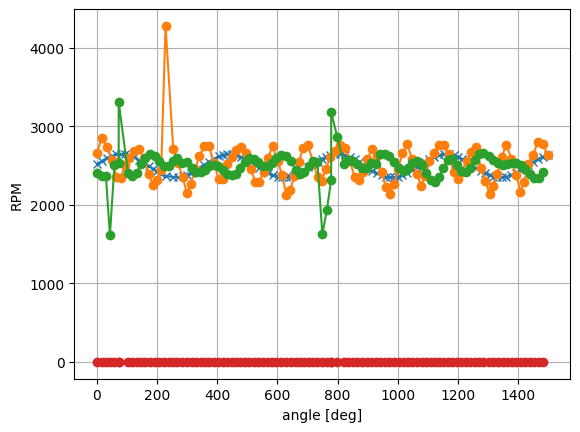

In [14]:
inds = range(100, 200)
# plt.subplot(2,1,1)
plt.plot(mecContAngle[inds]-mecContAngle[inds[0]], tarSpeedHz[inds]*60, 'x-')
plt.plot(mecContAngle[inds]-mecContAngle[inds[0]], contMecAngleSpeedHz[inds]*60,'-o')
plt.plot(spiContAngle[inds]-spiContAngle[inds[0]], contSpiAngleSpeedHz[inds]*60,'-o')
plt.plot(spiContAngle[inds]-spiContAngle[inds[0]], contEncAngleSpeedHz[inds]*60,'-o')
plt.ylabel('RPM')
plt.xlabel('angle [deg]')
plt.grid(True)
# plt.subplot(2,1,2)
# plt.plot(encoderAngle)
plt.show()

